Scipy example
===

Here we will perform a variation of the fit example using Scipy.

In [8]:
# This code example below was generated by Claude-3.5.
import numpy as np

def generate_random_data(pdf, x_range, num_samples=1000, num_bins=1000):
    """
    Generate random data using an arbitrary positive definite function as PDF.
    
    Parameters:
    pdf (callable): The probability density function
    x_range (tuple): The range of x values (min_x, max_x)
    num_samples (int): Number of samples to generate
    num_bins (int): Number of bins for discretization
    
    Returns:
    numpy.ndarray: Array of generated random data
    """
    
    min_x, max_x = x_range
    x = np.linspace(min_x, max_x, num_bins)
    y = pdf(x)
    
    # Ensure the function is non-negative
    if np.any(y < 0):
        raise ValueError("The input function must be non-negative in the given range")
    
    # Normalize the function to make it a valid PDF
    y_normalized = y / np.trapezoid(y, x)
    
    # Find the maximum value of the normalized PDF
    y_max = np.max(y_normalized)
    
    # Generate random samples using rejection sampling
    samples = []
    while len(samples) < num_samples:
        x_proposed = np.random.uniform(min_x, max_x)
        y_proposed = np.random.uniform(0, y_max)
        
        if y_proposed < pdf(x_proposed) / np.trapezoid(y, x): # notice how the AI includes this inefficiency
            samples.append(x_proposed)                    # can you speed this code up in the 2nd cell below?
    
    return np.array(samples)

In [9]:
# a function with three parameters
def sample_pdf(x, p0=0.5, p1=2, p2=25, p3=.1, norm=1.0):
        return norm*(p0 * np.exp(-(x - p1)**2 / 0.5) + x*x/p2 + p3)

In [10]:
%%timeit
data = generate_random_data(sample_pdf, (-5, 5), num_samples=10000)
# comment out this cell to go faster 

157 ms ± 2.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


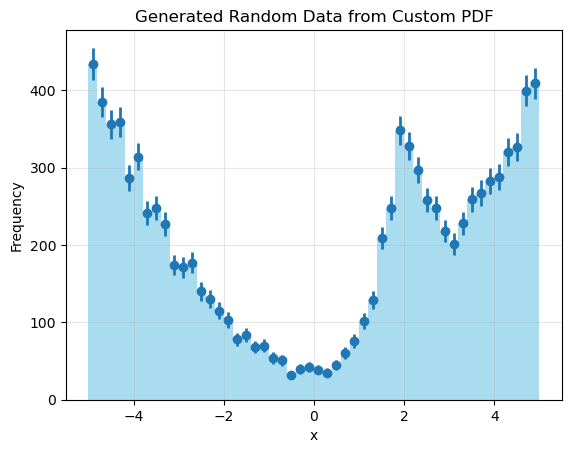

In [11]:
# back to the main project
import matplotlib.pyplot as plt

xrange=(-5,5)
nbins=50
data = generate_random_data(sample_pdf, xrange, num_samples=10000)
y,bins=np.histogram(data, bins=nbins, range=xrange)
yerr=np.sqrt(y)
x=(bins[:-1]+bins[1:])/2

plt.hist(data, bins=nbins, density=False, alpha=0.7, color='skyblue')

plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Generated Random Data from Custom PDF')
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
plt.grid(True, alpha=0.3)
plt.show()

Perform a fit using [scipy.optimize.curvefit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
---

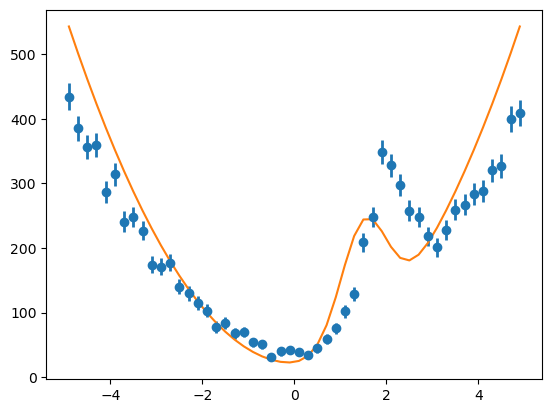

In [12]:
# fit the function sample_pdf to the data (x, y, yerr)
# first we need to 'guess' at initial parameters 
# (pretending here that we don't already know them)
params=[.4,1.5,20,0.05,y.max()]
ytmp = sample_pdf(x,*params)
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
plt.plot(x,ytmp)

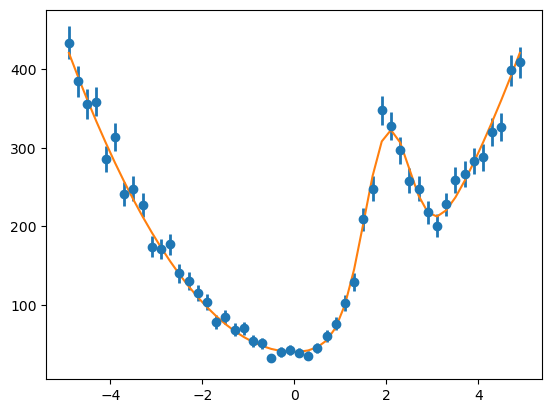

In [13]:
# that wasn't too bad for a 'guess'
# let's try fitting
from scipy.optimize import curve_fit
popt,pcov = curve_fit(sample_pdf, x, y, p0=params, sigma=yerr, absolute_sigma=True)
# the return values are the optimized parameters and the covariance matrix

# now let's see how the fit looks
plt.errorbar(x, y, yerr, fmt='o', linewidth=2)
ytmp = sample_pdf(x,*popt)
plt.plot(x,ytmp)

In [24]:
# extract the parabolic errors from the covariance function
perr = [] 
for i in range(len(popt)):
    try:
        perr.append(np.sqrt(pcov[i][i]))
    except:
        perr.append( 0.00 )
print("params     errors")
for i in range(len(popt)):
    print(f"{popt[i]:8.3f}  {perr[i]:0.3f}")

params     errors
   0.529  705770.057
   2.011  0.023
  25.786  34427890.758
   0.097  129194.020
 409.651  546945441.498


Wow, those errors look crazy!  I'm not sure what to tell you, except that I recommend using a package like [ROOT](https://root.cern.ch/), [lmfit](https://lmfit.github.io/lmfit-py/), or [iminuit](https://scikit-hep.org/iminuit/) instead!  The model above may have parameter correlations that are too strong for the scipy minimzer to do a proper error estimation.  What do you think is happening?

In [18]:
# want the chi^2?  you need to do it on your own
chi2=np.square((y-ytmp)/yerr).sum()
import scipy.stats as stats
ndof=len(x)-len(popt)
p_value = 1 - stats.chi2.cdf(chi2, ndof)
print(f"chi2 = {chi2:0.2f} p-value = {p_value:0.2g}")

chi2 = 44.23 p-value = 0.5


For you to try
===
The file datadist.root you will find a histogram representing data from an unknown distribution.

* Develop your own fitting function/model and see how well you can fit this distribution. 
* You may need to try a variety of functions.
* Include a plot of your best fit at the bottom of this notebook.
* Include your p-value for the best fit and describe how you settled on this fit versus others.
* Show your best fit parameters and their errors
* Plot the fit residuals, eg for each bin plot (fit-data)/data_uncertianty.  For a good fit the points should randomy fluctuate around 0 (eg no large, contiguous regions above or below 0)
* Plot the pull distribution (for a good fit this should be consisten with a normal distribution w/ $\mu=0,\sigma=1$

For this notebook it is assumed that you'll woth with scipy.optimize.curve_fit.  Below, we'll first conver the ROOT instogram into numpy arrays.

Welcome to JupyROOT 6.28/10


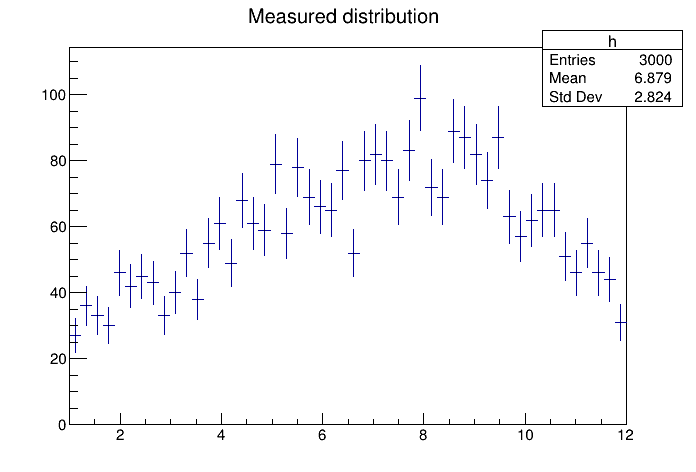

In [10]:
import ROOT as r
tf=r.TFile("datadist.root")
hist=tf.Get("h")
tc=r.TCanvas()
hist.Draw()
tc.Draw()

In [11]:
# a basic function to convert ROOT histograms into numpy arrays
def hist2np(h):
    nbin=h.GetNbinsX()
    x=np.zeros(nbin)
    y=np.zeros(nbin)
    ey=np.zeros(nbin)
    for i in range(1,nbin+1):  # bin index is 1..N
        x[i-1]=h.GetBinCenter(i)
        y[i-1]=h.GetBinContent(i)
        ey[i-1]=h.GetBinError(i)
    return x,y,ey

<ErrorbarContainer object of 3 artists>

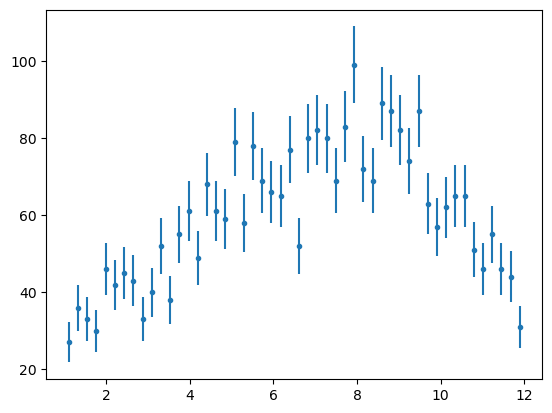

In [12]:
# Plot the histogram data with error bars
x,y,yerr = hist2np(hist)

plt.errorbar(x, y, yerr=yerr, fmt='.')

In [13]:
# your work here - I was keep getting cling error when attepted to use ROOT, so will use uproot

In [5]:
%pip install -q --user uproot awkward scipy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [7]:
import os, numpy as np, uproot
os.makedirs("figs", exist_ok=True)

h = uproot.open("datadist.root")["h"]
try:
    y = np.asarray(h.values(flow=False))
    edges = np.asarray(h.axes[0].edges())
except Exception:
    y, edges = h.numpy()

x = 0.5 * (edges[:-1] + edges[1:])
yerr = np.sqrt(np.maximum(y, 1.0))

In [16]:
from scipy import optimize, stats, signal
import numpy as np

def model2(x, bkg_scale, alpha, beta, A1, mu1, sig1, A2, mu2, sig2):
    bg = (x / beta) ** (-alpha)
    p1 = A1 * np.exp(-0.5 * ((x - mu1) / sig1) ** 2)
    p2 = A2 * np.exp(-0.5 * ((x - mu2) / sig2) ** 2)
    return bkg_scale * bg + p1 + p2

xr = x.max() - x.min()
sig_min, sig_max = 0.01*xr, 0.6*xr
beta_min, beta_max = 0.1, 10.0*x.max()

peaks, _ = signal.find_peaks(y, prominence=max(y)*0.02 if y.size else 1.0)
xs = np.sort(x[peaks]) if peaks.size else np.array([])
if xs.size >= 2:
    mu1_seed, mu2_seed = xs[0], xs[-1]
else:
    mu1_seed = x[np.argmax(y)]
    mu2_seed = mu1_seed + 0.25*xr

if 'popt1' in globals():
    bkg0, a0, A10, mu10, s10 = float(popt1[0]), float(popt1[1]), float(popt1[2]), float(popt1[3]), float(popt1[4])
else:
    bkg0, a0 = float(max(y)), 4.0
    A10, mu10, s10 = float(max(y)), float(mu1_seed), 0.06*xr

lb = np.array([0.0, 1e-6, beta_min, 0.0, x.min(),  sig_min, 0.0, x.min(),  sig_min], float)
ub = np.array([1e12, 10.0,  beta_max, 1e12, x.max(), sig_max, 1e12, x.max(), sig_max], float)

best = None
rng = np.random.default_rng(123)
for _ in range(16):
    beta0 = float(np.clip(np.median(x)*(1+0.5*rng.normal()), beta_min+1e-8, beta_max-1e-8))
    A20   = 0.2*max(y)*abs(1+0.5*rng.normal())
    mu20  = float(np.clip(mu2_seed + 0.15*xr*rng.normal(), x.min(), x.max()))
    sig20 = float(np.clip(0.08*xr*abs(1+rng.normal(0,0.5)), sig_min+1e-8, sig_max-1e-8))
    p0 = np.array([bkg0, a0, beta0, A10, mu10, s10, A20, mu20, sig20], float)
    p0 = np.minimum(np.maximum(p0, lb+1e-8), ub-1e-8)
    try:
        popt2, pcov2 = optimize.curve_fit(
            model2, x, y, p0=p0, sigma=yerr, absolute_sigma=True,
            bounds=(lb, ub), maxfev=200000
        )
        yfit2  = model2(x, *popt2)
        chi2_2 = float(np.sum((y - yfit2)**2 / yerr**2))
        ndf_2  = max(len(x) - len(popt2), 1)
        pval_2 = float(stats.chi2.sf(chi2_2, ndf_2))
        score  = chi2_2/ndf_2
        if (best is None) or (score < best[0]):
            best = (score, chi2_2, ndf_2, pval_2, popt2, pcov2, yfit2)
    except Exception:
        pass

score, chi2_2, ndf_2, pval_2, popt2, pcov2, yfit2 = best
resid2 = (yfit2 - y) / yerr
pulls2 = (y - yfit2) / yerr
print("two-Gaussian: chi2/ndf =", chi2_2, "/", ndf_2, " p =", pval_2)
for n, v, e in zip(["bkg_scale","alpha","beta","A1","mu1","sig1","A2","mu2","sig2"],
                    popt2, np.sqrt(np.diag(pcov2))):
    print(f"{n} = {v} +/- {e}")


two-Gaussian: chi2/ndf = 51.856006386482285 / 41  p = 0.11918368575683014
bkg_scale = 32.397484717243934 +/- 82855.59502827824
alpha = 0.0008487693002598661 +/- 0.16695885953424588
beta = 7.767434105360643 +/- 23404568.884203188
A1 = 48.31555820280944 +/- 10.414510203855686
mu1 = 8.571316212239434 +/- 0.46847820171918764
sig1 = 1.6753809261682593 +/- 0.579017163739928
A2 = 27.305398076780914 +/- 8.16982707075699
mu2 = 4.99086819578423 +/- 0.7712634966256121
sig2 = 1.365901639989534 +/- 0.4411168423647833


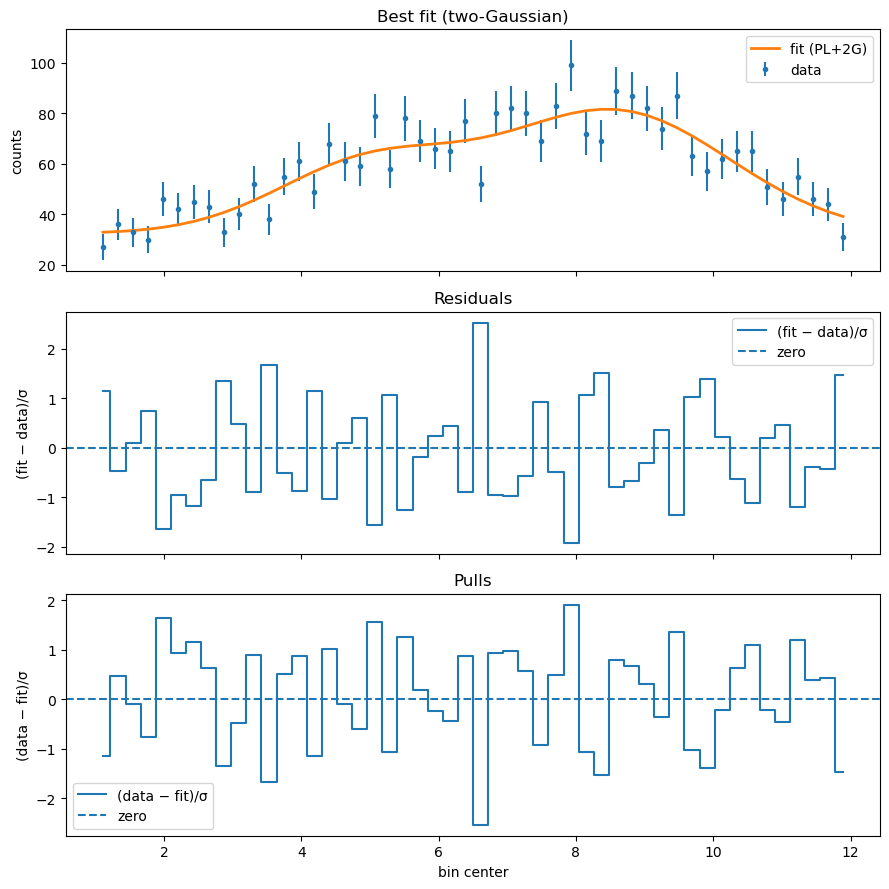

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(9,9), sharex=True)
axes[0].errorbar(x, y, yerr=yerr, fmt='o', ms=3, label='data')
axes[0].plot(x, yfit2, lw=2, label='fit (PL+2G)')
axes[0].set_title('Best fit (two-Gaussian)')
axes[0].set_ylabel('counts')
axes[0].legend()
axes[1].plot(x, resid2, drawstyle="steps-mid", label='(fit − data)/σ')
axes[1].axhline(0, linestyle="--", label='zero')
axes[1].set_title('Residuals')
axes[1].set_ylabel('(fit − data)/σ')
axes[1].legend()
axes[2].plot(x, pulls2, drawstyle="steps-mid", label='(data − fit)/σ')
axes[2].axhline(0, linestyle="--", label='zero')
axes[2].set_title('Pulls')
axes[2].set_xlabel('bin center')
axes[2].set_ylabel('(data − fit)/σ')
axes[2].legend()
plt.tight_layout()
plt.savefig('figs/fit_residuals_pulls_twoG.png')
plt.show()


pull mean = 0.06908882389846874 pull std = 1.0263601546061296


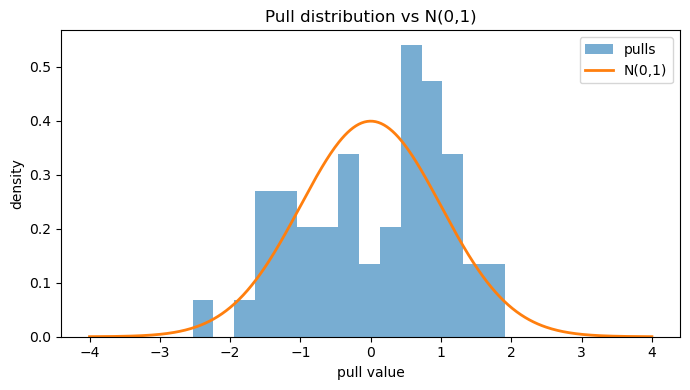

In [19]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

p = pulls2
mu_pull = float(np.mean(p))
sd_pull = float(np.std(p, ddof=1))
print("pull mean =", mu_pull, "pull std =", sd_pull)

xx = np.linspace(-4, 4, 400)
plt.figure(figsize=(7,4))
plt.hist(p, bins=15, density=True, alpha=0.6, label='pulls')
plt.plot(xx, norm.pdf(xx, 0, 1), lw=2, label='N(0,1)')
plt.title('Pull distribution vs N(0,1)')
plt.xlabel('pull value'); plt.ylabel('density'); plt.legend()
plt.tight_layout(); plt.savefig('figs/pull_hist.png'); plt.show()


In [20]:
from scipy import optimize, signal, stats
import numpy as np

x0 = float(np.median(x))

def model1(x, bkg_scale, alpha, A, mu, sig):
    bg = (x / x0) ** (-alpha)
    peak = A * np.exp(-0.5 * ((x - mu) / sig) ** 2)
    return bkg_scale * bg + peak

peaks, _ = signal.find_peaks(y, prominence=max(y)*0.02 if y.size else 1.0)
xs = np.sort(x[peaks]) if peaks.size else np.array([])
mu_seed = xs[np.argmax(y[peaks])] if xs.size else x[np.argmax(y)]
sig0 = 0.05 * (x.max() - x.min())

p01 = np.array([max(y), 4.0, max(y), mu_seed, sig0], float)
lb1 = np.array([0.0, 1e-6, 0.0, x.min(), 1.0], float)
ub1 = np.array([1e12, 10.0, 1e12, x.max(), 300.0], float)
eps = 1e-8
p01 = np.minimum(np.maximum(p01, lb1 + eps), ub1 - eps)

popt1, pcov1 = optimize.curve_fit(
    model1, x, y, p0=p01, sigma=yerr, absolute_sigma=True,
    bounds=(lb1, ub1), maxfev=200000
)

yfit1  = model1(x, *popt1)
resid1 = (yfit1 - y) / yerr
pulls1 = (y - yfit1) / yerr
chi2_1 = float(np.sum((y - yfit1)**2 / yerr**2))
ndf_1  = max(len(x) - len(popt1), 1)
pval_1 = float(stats.chi2.sf(chi2_1, ndf_1))
errs1  = np.sqrt(np.diag(pcov1))

print("one-Gaussian: chi2/ndf =", chi2_1, "/", ndf_1, " p =", pval_1)
for n, v, e in zip(["bkg_scale","alpha","A","mu","sig"], popt1, errs1):
    print(f"{n} = {v} +/- {e}")


one-Gaussian: chi2/ndf = 58.87295388332006 / 45  p = 0.08029555549715703
bkg_scale = 11.425767074026664 +/- 33.203413042764645
alpha = 0.3619962659278891 +/- 1.224438006237003
A = 68.0505480199999 +/- 32.32509209783872
mu = 7.651863247254077 +/- 0.14927970396977733
sig = 3.434186645211411 +/- 1.177963925439808


Final p value was 0.119, and reduced chi squared was 1.266. I compared power law + one gaussian with power law + two gaussians. Two gaussian model clearly won as shown in the p value and reduced chi^2 value, showing that it cleanly captured the second bump with sensible uncertainties. 